In [1]:
%load_ext autoreload
%autoreload 2

# Validation Notebook

In [2]:
import xarray as xr
import xskillscore as xs
import numpy as np
import os
import cartopy.crs as ccrs

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
xr.set_options(keep_attrs=True)
xr.set_options(display_style='text')

In [5]:
OUTPUT = '***BASEDIR***'

# Validation class

In [6]:
import os
import xarray as xr
import pandas as pd


class Validation():
    def __init__(self, observation_path: str, prediction_path: str) -> None:
        
        if not os.path.exists(observation_path):
            print("Observation path file is not existing or unreachable")
            return
        if not os.path.exists(prediction_path):
            print("Prediction path file is not existing or unreachable")
            return
   
        self.observation_path = observation_path
        self.prediction_path = prediction_path
        
        self.obs: xr.Dataset = xr.Dataset()
        self.preds: xr.Dataset = xr.Dataset()
        self.clim_p: xr.DataArray = xr.DataArray()
            
        self.rps_ml: xr.Dataset = xr.Dataset()
        self.rps_clim: xr.Dataset = xr.Dataset()
            
        self.regions_positions: dict = {'North_America': (slice(0, 50), slice(120, 300)),
                                        'South_America': (slice(40, 100), slice(150, 300)),
                                        'Europe_Africa_Asia': (slice(0, 100), slice(0, 60)),
                                        'Oceania': (slice(50, 100), slice(70, 120))}
            
        self.regions_positions_orthographic: dict = {'North_America': (-80, 25),
                                                     'South_America': (-60, -15),
                                                     'Europe_Africa_Asia': (50, 25),
                                                     'Oceania': (120, 1)}

        self.__open_files()
        self.__initialise_climatology_probabilities()
        self.__assert_predictions_2020(self.obs)
        self.__assert_predictions_2020(self.preds)
        self.__compute_RPS()

        print("Validation class successfully initialised")
        
    
    def __open_files(self) -> None:      
        try:
            self.obs = xr.open_dataset(self.observation_path)
            self.preds = xr.open_dataset(self.prediction_path)
        except Exception as e:
            print('Found Exception', str(e))
            
            
    def __initialise_climatology_probabilities(self) -> None:
        """
        REFORMAT FROM ORGANIZERS NOTEBOOKS
        Initialize the climatology DataArray to 1/3 values for each categories
        """
        self.clim_p = xr.DataArray([1/3, 1/3, 1/3], dims='category', coords={'category':['below normal', 'near normal', 'above normal']}).to_dataset(name='tp')
        self.clim_p['t2m'] = self.clim_p['tp']
        
    def __assert_predictions_2020(self, preds_test) -> None:
        """
        REFORMAT FROM ORGANIZERS NOTEBOOKS
        Check the variables, coordinates and dimensions of 2020 predictions.
        """
        
        # is dataset
        assert isinstance(preds_test, xr.Dataset)

        # has both vars: tp and t2m
        assert 'tp' in preds_test.data_vars
        assert 't2m' in preds_test.data_vars

        ## coords
        # forecast_time
        d = pd.date_range(start='2020-01-02', freq='7D', periods=53)
        forecast_time = xr.DataArray(d, dims='forecast_time', coords={'forecast_time':d})
        assert (forecast_time == preds_test['forecast_time']).all()

        # longitude
        lon = np.arange(0., 360., 1.5)
        longitude = xr.DataArray(lon, dims='longitude', coords={'longitude': lon})
        assert (longitude == preds_test['longitude']).all()

        # latitude
        lat = np.arange(90., -90.1, 1.5)
        latitude = xr.DataArray(lat, dims='latitude', coords={'latitude': lat})
        assert (latitude == preds_test['latitude']).all()

        # lead_time
        lead = [pd.Timedelta(f'{i} d') for i in [14, 28]]
        lead_time = xr.DataArray(lead, dims='lead_time', coords={'lead_time': lead})
        assert (lead_time == preds_test['lead_time']).all()

        # category
        cat = np.array(['below normal', 'near normal', 'above normal'], dtype='<U12')
        category = xr.DataArray(cat, dims='category', coords={'category': cat})
        assert (category == preds_test['category']).all()

        # size
        from dask.utils import format_bytes
        size_in_MB = float(format_bytes(preds_test.nbytes).split(' ')[0])
        assert size_in_MB > 50
        assert size_in_MB < 250

        # no other dims
        assert set(preds_test.dims) - {'category', 'forecast_time', 'latitude', 'lead_time', 'longitude'} == set()
        
        
    def __compute_RPS(self, plot=True):
        self.rps_ml = xs.rps(self.obs, self.preds, category_edges=None, dim='forecast_time', input_distributions='p').compute()               
        self.rps_clim = xs.rps(self.obs, self.clim_p, category_edges=None, dim='forecast_time', input_distributions='p').compute()
        
            
    def plot_rps(self) -> None:
        for v in self.rps_ml.data_vars:
            self.rps_ml[v].plot(robust=True, col='lead_time', figsize=(10,5))

        for v in self.rps_clim.data_vars:
            self.rps_clim[v].plot(robust=True, col='lead_time', figsize=(10,5))
        
    def __compute_tropic_mask(self, rpss: xr.Dataset) -> xr.Dataset:
        
        mask = xr.ones_like(rpss.isel(lead_time=0, drop=True)).reset_coords(drop=True).t2m
        boundary_tropics = 30
        mask = xr.concat([mask.where(mask.latitude > boundary_tropics),
                          mask.where(np.abs(mask.latitude) <= boundary_tropics),
                          mask.where((mask.latitude < -boundary_tropics) & (mask.latitude > -60))], 'area')
        mask = mask.assign_coords(area=['northern_extratropics', 'tropics', 'southern_extratropics'])
        mask.name = 'area'

        return mask.where(rpss.t2m.isel(lead_time=0, drop=True).notnull())
        
    def compute_scores_from_organizers_RPSS(self) -> pd.DataFrame:
        """
        REFORMAT FROM ORGANIZERS NOTEBOOKS
        Compute RPSS according to notebook organizers
        """
        self.rpss_organizers = (1 - self.rps_ml / self.rps_clim)
        
        mask = self.__compute_tropic_mask(self.rps_ml)      
        weights = np.cos(np.deg2rad(np.abs(mask.latitude)))
        
        scores = (self.rpss_organizers*mask).weighted(weights).mean('latitude').mean('longitude')
        
        return scores.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2)
    
    def compute_scores_from_arlan_RPSS(self) -> pd.DataFrame:
        """
        Compute RPSS according to Arlan's definition
        """
        
        mask = self.__compute_tropic_mask(self.rps_ml)      
        weights = np.cos(np.deg2rad(np.abs(mask.latitude)))
        
        latitude_longitude_sum_ML = (self.rps_ml*mask).weighted(weights).sum(dim=['latitude', 'longitude'])
        latitude_longitude_sum_clim = (self.rps_clim*mask).weighted(weights).sum(dim=['latitude', 'longitude'])
        
        self.rpss_arlan = 1 - latitude_longitude_sum_ML/latitude_longitude_sum_clim
        
        scores = (self.rpss_arlan*mask).weighted(weights).mean('latitude').mean('longitude')
        
        return scores.reset_coords(drop=True).to_dataframe().unstack(0).T.round(2)
    
    
    def plot_by_region(self, what:str='observations', feat:str='t2m', region:str='North_America', category:int=2, forecast_time:int=0, orthographic: bool=False):
        
        assert 't2m' or 'tp' in feat
        assert region in list(val.regions_positions.keys())
        assert category <= 2
        
        print('Plot', feat,'for category n°', category, 'for', what, 'data for', region, 'for forecast_time', forecast_time)
        
        latitude: slice = self.regions_positions[region][0]
        longitude: slice = self.regions_positions[region][1]
            
        orthographic_pos = self.regions_positions_orthographic[region]
                    
        if what == 'observations':
            if not orthographic:
                self.obs[feat].isel(category=category, 
                                    forecast_time=forecast_time, 
                                    latitude=latitude, 
                                    longitude=longitude).plot(col='lead_time', figsize=(10,5))
            else:
                self.obs[feat].isel(category=category, 
                                    forecast_time=forecast_time).plot(col='lead_time', subplot_kws=dict(projection=ccrs.Orthographic(orthographic_pos[0], orthographic_pos[1]), facecolor="gray"),
                                                                     transform=ccrs.PlateCarree(), 
                                                                     figsize=(20,20))
        elif what == 'predictions':
            if not orthographic:
                self.preds[feat].isel(category=category, 
                                      forecast_time=forecast_time, 
                                      latitude=latitude, 
                                      longitude=longitude).plot(col='lead_time', figsize=(10,5))
            else:
                self.preds[feat].isel(category=category, 
                                    forecast_time=forecast_time).plot(col='lead_time', subplot_kws=dict(projection=ccrs.Orthographic(orthographic_pos[0], orthographic_pos[1]), facecolor="gray"),
                                                                      transform=ccrs.PlateCarree(),
                                                                      figsize=(20,20))
        else:
            print(what, 'is not in possible visualisation. Try observations or predictions')

In [7]:
val = Validation(os.path.join(OUTPUT, 'forecast-like-observations_2020_biweekly_terciled.nc'), 
                 os.path.join(OUTPUT, 'ML_prediction_2020.nc'))

Validation class successfully initialised


Plot t2m for category n° 2 for predictions data for North_America for forecast_time 0


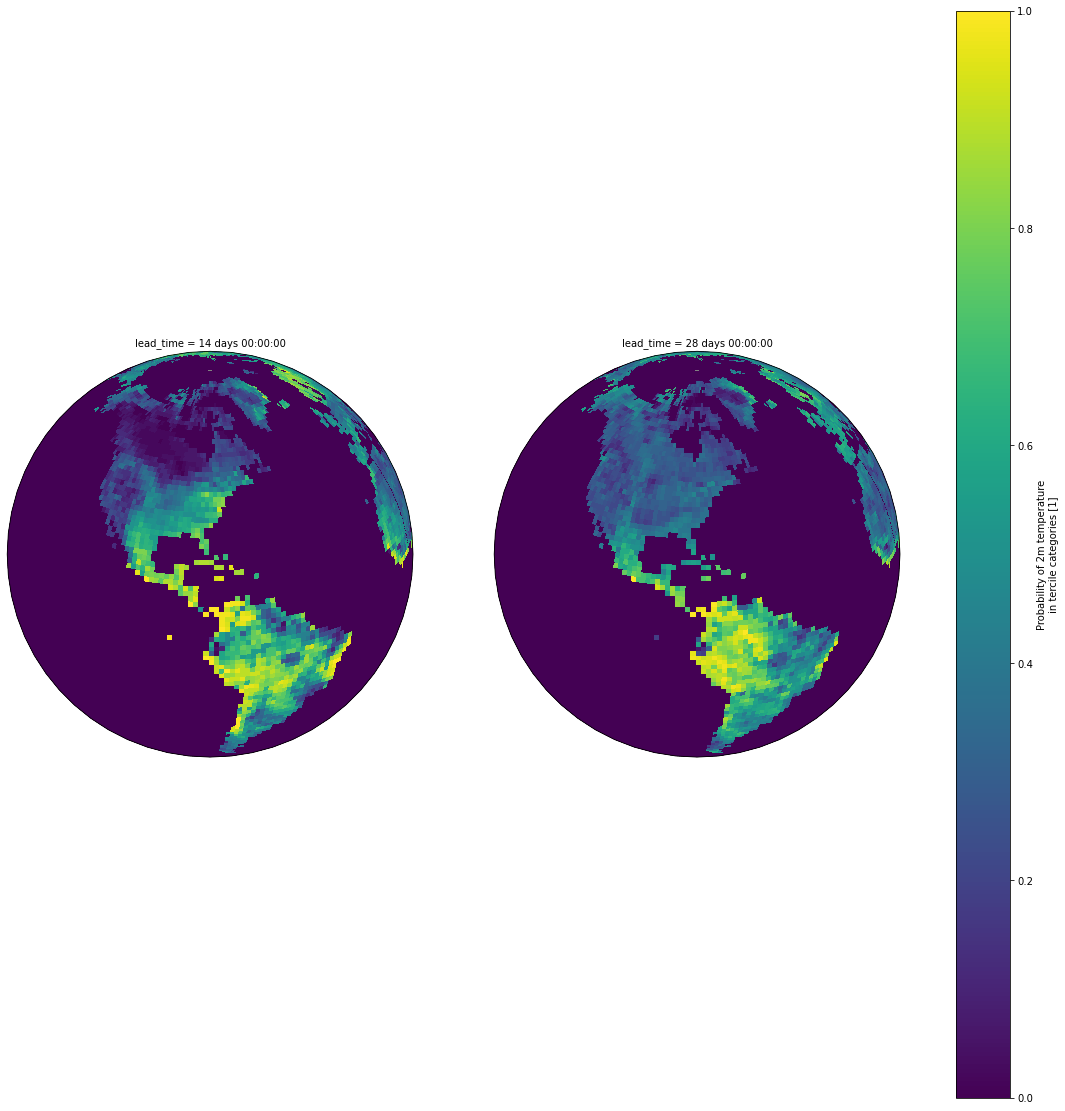

In [8]:
val.plot_by_region(what='predictions', region='North_America', orthographic=True)

Plot t2m for category n° 2 for predictions data for Europe_Africa_Asia for forecast_time 0


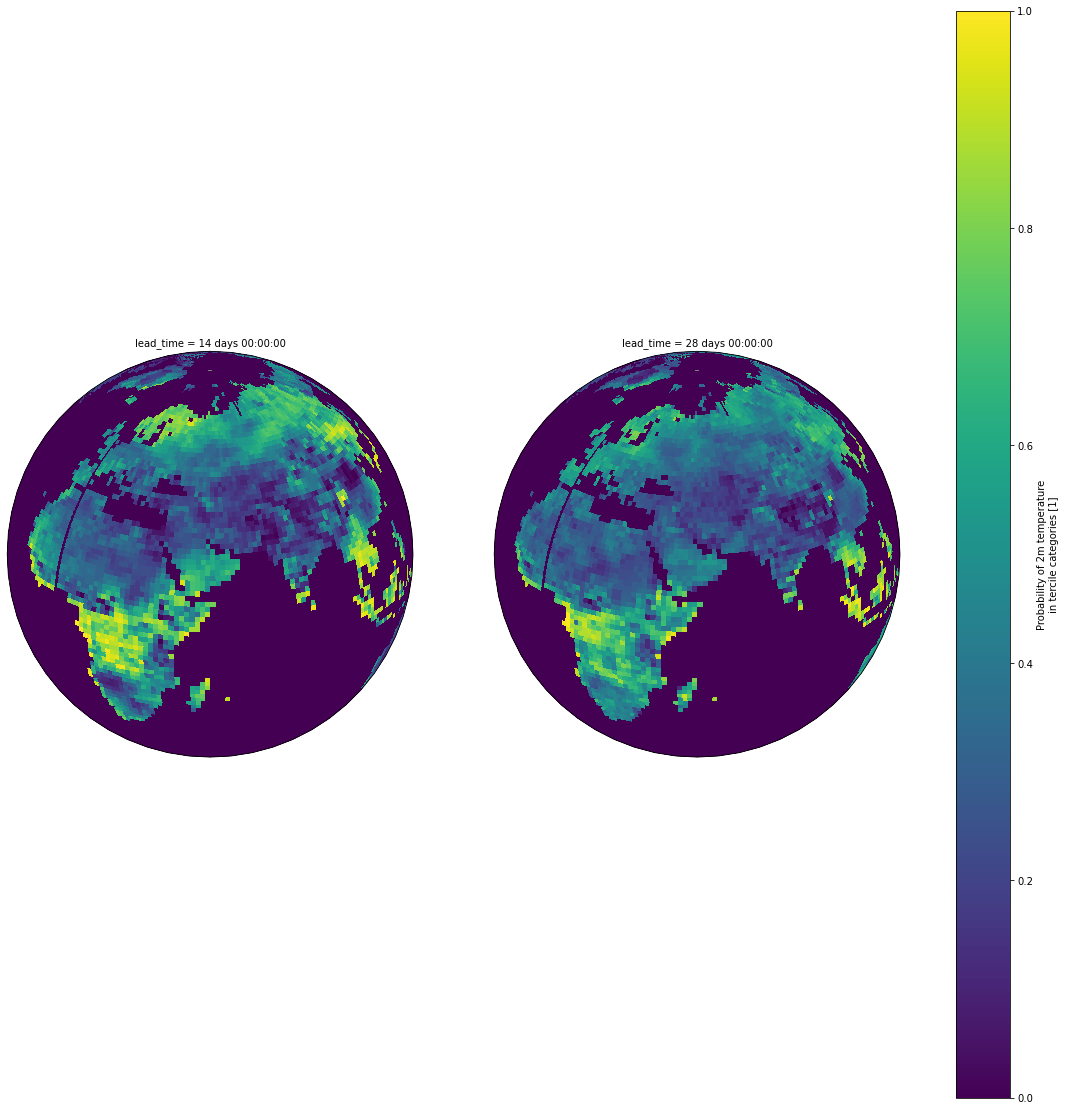

In [9]:
val.plot_by_region(what='predictions', region='Europe_Africa_Asia', orthographic=True)

Plot t2m for category n° 2 for predictions data for Oceania for forecast_time 0


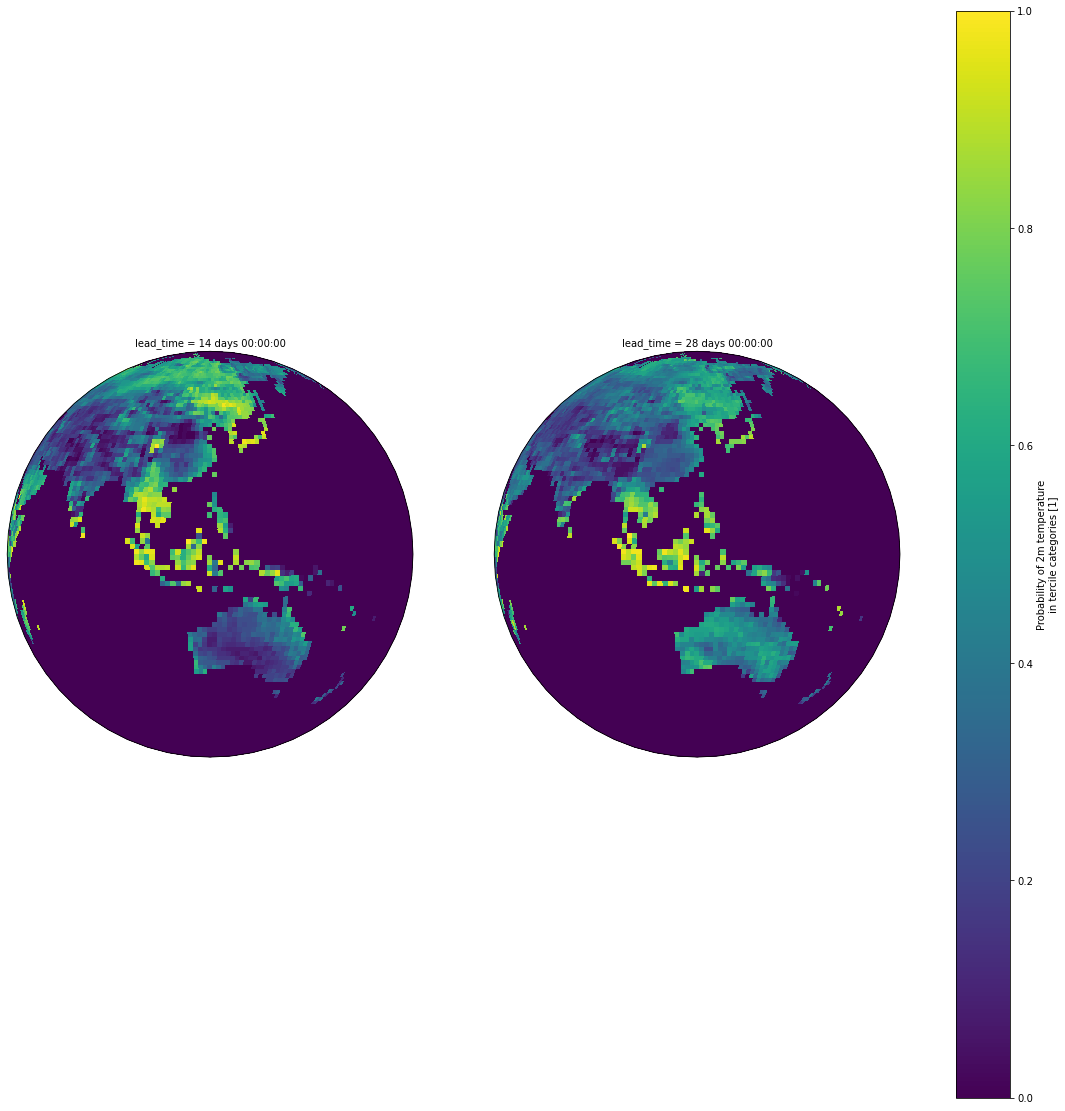

In [10]:
val.plot_by_region(what='predictions', region='Oceania', orthographic=True)

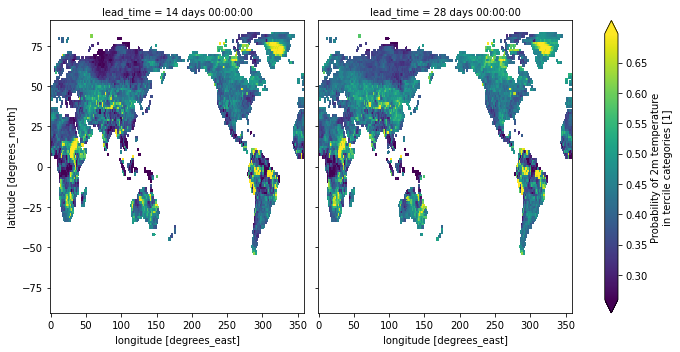

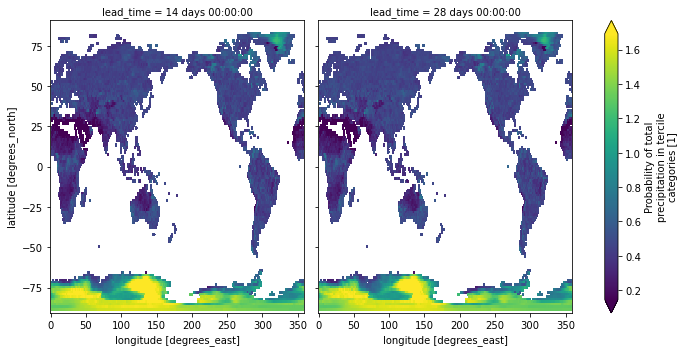

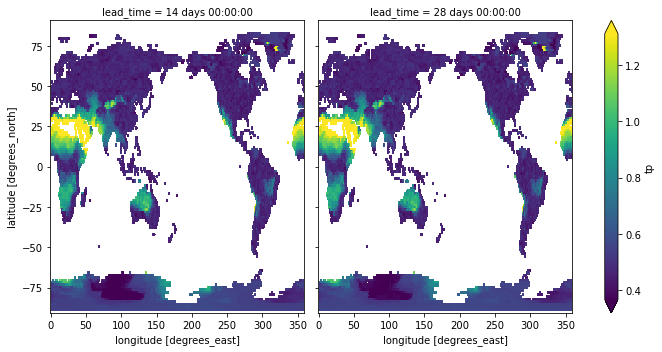

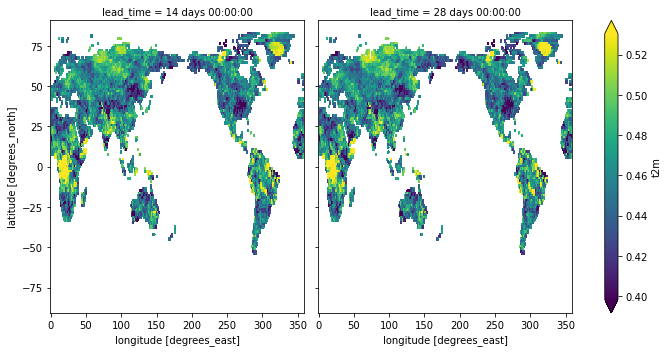

In [11]:
val.plot_rps()

In [12]:
val.compute_scores_from_organizers_RPSS()

lead_time                  14 days  28 days
    area                                   
t2m northern_extratropics     0.06     0.02
    tropics                   0.08     0.06
    southern_extratropics     0.03    -0.01
tp  northern_extratropics    -0.02    -0.03
    tropics                   0.35     0.33
    southern_extratropics    -0.05    -0.07

In [13]:
val.compute_scores_from_arlan_RPSS()

lead_time                  14 days  28 days
    area                                   
t2m northern_extratropics     0.09     0.04
    tropics                   0.08     0.06
    southern_extratropics     0.08     0.02
tp  northern_extratropics     0.07     0.05
    tropics                   0.50     0.48
    southern_extratropics    -0.03    -0.05

In [139]:
def select_from_month(date="2020-01"):
    position = np.where(val.preds.forecast_time.data.astype("datetime64[M]") == np.datetime64(date))[0]
    return val.preds.isel(forecast_time=slice(position.min(), position.max()))

In [141]:
select_from_month("2020-03")

<xarray.DataArray 'forecast_time' (forecast_time: 3)>
array(['2020-03-05T00:00:00.000000000', '2020-03-12T00:00:00.000000000',
       '2020-03-19T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-03-05 ... 2020-03-19
Attributes:
    description:    The forecast reference time in NWP is the "data time", th...
    long_name:      initial time of forecast
    standard_name:  forecast_reference_time

In [14]:
val.preds

<xarray.Dataset>
Dimensions:        (category: 3, forecast_time: 53, latitude: 121, lead_time: 2, longitude: 240)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (lead_time, forecast_time) datetime64[ns] ...
  * category       (category) object 'below normal' 'near normal' 'above normal'
Data variables:
    t2m            (category, lead_time, forecast_time, latitude, longitude) float32 ...
    tp             (category, lead_time, forecast_time, latitude, longitude) float32 ...
Attributes:
    author:        Aaron Spring
    author_email:  aaron.spring@mpimet.mpg.de
    comment:       created for the s2s-ai-challenge as a template for the web...
    notebook:      mean_bias_reduction.ipynb
    website:       https://s2s-ai-challenge.github.io/#evaluation

In [18]:
val.obs

<xarray.Dataset>
Dimensions:        (category: 3, forecast_time: 53, latitude: 121, lead_time: 2, longitude: 240)
Coordinates:
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 ... 2020-12-31
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time      (lead_time) timedelta64[ns] 14 days 28 days
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (lead_time, forecast_time) datetime64[ns] ...
  * category       (category) object 'below normal' 'near normal' 'above normal'
Data variables:
    t2m            (category, lead_time, forecast_time, latitude, longitude) float32 ...
    tp             (category, lead_time, forecast_time, latitude, longitude) float32 ...

In [16]:
val.rps_ml

<xarray.DataArray 't2m' (lead_time: 2, latitude: 121, longitude: 240)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * lead_time  (lead_time) timedelta64[ns] 14 days 28 days
  * longitude  (longitude) float64 0.0 1.5 3.0 4.5 ... 354.0 355.5 357.0 358.5
Attributes:
    long_name:                       Probability of 2m temperature in tercile...
    units:                           1
    comment:                         All three tercile category probabilities...
    variable_before_categorization:  https://confluence.ecmwf.int/display/S2S...

In [ ]:
# Printemps le 20 mars
# Été le 20 juin
# Automne 22 septembre
# Hiver 21 decembre